## Import Libraries and Models


In [1]:
from collections import defaultdict
import copy
import random
import os
import sys
import shutil
from urllib.request import urlretrieve
#from imutils import paths #Python library that provides a collection of convenience functions for common tasks in computer vision and image processing
#from sklearn.model_selection import train_test_split  #An open-source Python library that provides a wide range of tools and algorithms for machine learning, data mining, and data analysis.
import json
import importlib
import logging

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np


import albumentations as A
from albumentations.pytorch import ToTensorV2


import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn #All neural network modules, nn.linear, nn.conv2d, BatchNorm, Loss functions
import torch.optim as optim #For all optimization algorithms SGD, Adam
import torch.nn.functional as F #All functions that dont have any parameter
from torch.utils.data import Dataset, DataLoader #Pytorch standard dataset and its management
from torchsummary import summary

from tqdm import tqdm

import segmentation_models_pytorch as smp
from UTNet.model.utnet import UTNet
from DTrC_Net import CTCNet
#import CTCNet

cudnn.benchmark = True



/home/ali/miniconda3/envs/seg_prac/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Check Pytorch Installation

In [2]:
#Check Pytorch Installation
print(torch.version.__version__, torch.cuda.is_available())

2.1.2+cu118 True


## Dataset Loading and Visualization

In [3]:
# Defining a function to visualize the dataset and their labels (masks-binary)
# Function to normalize the mask for better visualization
def normalize_array(array):
    array_min = array.min()
    array_max = array.max()
    normalized_array = (array - array_min) / (array_max - array_min) * 255
    return normalized_array.astype(np.uint8)

# Function to visualize a grid of images with associated masks
def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None, font_size=12):
    # Determine the number of columns and adjust figsize accordingly
    cols = 5 if predicted_masks else 3  # More columns if predicted masks are included
    rows = len(images_filenames)
    # Set the figsize dynamically based on the number of columns
    base_figsize_width = 10  # Base width for three columns
    base_figsize_height = 24  # Base height for the given number of rows
    extra_width_per_col = 2  # Additional width for each extra column

    # Calculate the appropriate figsize based on the number of columns
    figsize_width = base_figsize_width + (cols - 3) * extra_width_per_col
    figsize = (figsize_width, base_figsize_height)

    # Create the subplot grid with the dynamic figsize
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)

    # Loop through the image filenames and display them along with their masks
    for i, image_filename in enumerate(images_filenames):
        # Load the image
        image_path = os.path.join(images_directory, image_filename)
        image = np.array(Image.open(image_path).convert("RGB"))

        # Load the mask and create an overlay
        mask_path = os.path.join(masks_directory, image_filename.replace(".jpg", ".png"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        #print("Unique pixel values in mask:", np.unique(mask))
        mask_color = cv2.applyColorMap(np.uint8(mask * 2), cv2.COLORMAP_JET)
        overlay_mask = cv2.addWeighted(image, 0.6, mask_color, 0.4, 0)

        # Display the original image, mask, and overlay
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, cmap='gray')
        ax[i, 2].imshow(overlay_mask)

        # Set the titles with the specified font size
        ax[i, 0].set_title("Image", fontsize=10)
        ax[i, 1].set_title("Ground Truth Mask", fontsize=10)
        ax[i, 2].set_title("Overlay of Image with GT Mask", fontsize=10)

        # Turn off axes
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()

        # If there are predicted masks, add them to the plot
        if predicted_masks:
            # Predicted mask normalization and color mapping
            predicted_mask = normalize_array(predicted_masks[i])  # Normalize for better color mapping
            #predicted_mask = predicted_masks[i]
            #print("Unique pixel values in mask:", np.unique(mask))
            predicted_mask_color = cv2.applyColorMap(np.uint8(predicted_mask * 2), cv2.COLORMAP_JET)
            #predicted_mask_color = cv2.applyColorMap(predicted_mask, cv2.COLORMAP_MAGMA)  # Better color map
            overlay_predicted_mask = cv2.addWeighted(image, 0.6, predicted_mask_color, 0.4, 0)

            # Display the predicted mask and overlay
            ax[i, 3].imshow(predicted_mask, cmap='gray')
            ax[i, 4].imshow(overlay_predicted_mask)

            # Set titles with the specified font size
            ax[i, 3].set_title("Predicted Mask", fontsize=10)
            ax[i, 4].set_title("Overlay of Image with Predicted Mask", fontsize=10)

            # Turn off axes
            ax[i, 3].set_axis_off()
            ax[i, 4].set_axis_off()

    # Adjust layout and display the plot
    plt.tight_layout()  # Adjust spacing to avoid overlaps
    plt.show()

In [118]:
# Loading the images and masks dataset and then visualizing them
train_dataset_root_directory = os.path.join(os.environ["HOME"], "Segmentation_Project/CrackDataset_2/Train") 
valid_dataset_root_directory = os.path.join(os.environ["HOME"], "Segmentation_Project/CrackDataset_2/Valid")

train_images_dataset_path = os.path.join(train_dataset_root_directory, "Images") # provide the train images path
train_masks_dataset_path = os.path.join(train_dataset_root_directory, "Masks")    # provide the train masks path

valid_images_dataset_path = os.path.join(valid_dataset_root_directory, "Images") # provide the valid images path
valid_masks_dataset_path = os.path.join(valid_dataset_root_directory, "Masks")    # provide the valid masks path

train_images_filenames = list(sorted(os.listdir(train_images_dataset_path)))
valid_images_filenames = list(sorted(os.listdir(valid_images_dataset_path)))
#masks_dataset_filenames = list(sorted(os.listdir(masks_dataset_path)))\

print("Training dataset size:", len(train_images_filenames))
print("Validation dataset size:", len(valid_images_filenames))

Training dataset size: 2595
Validation dataset size: 321


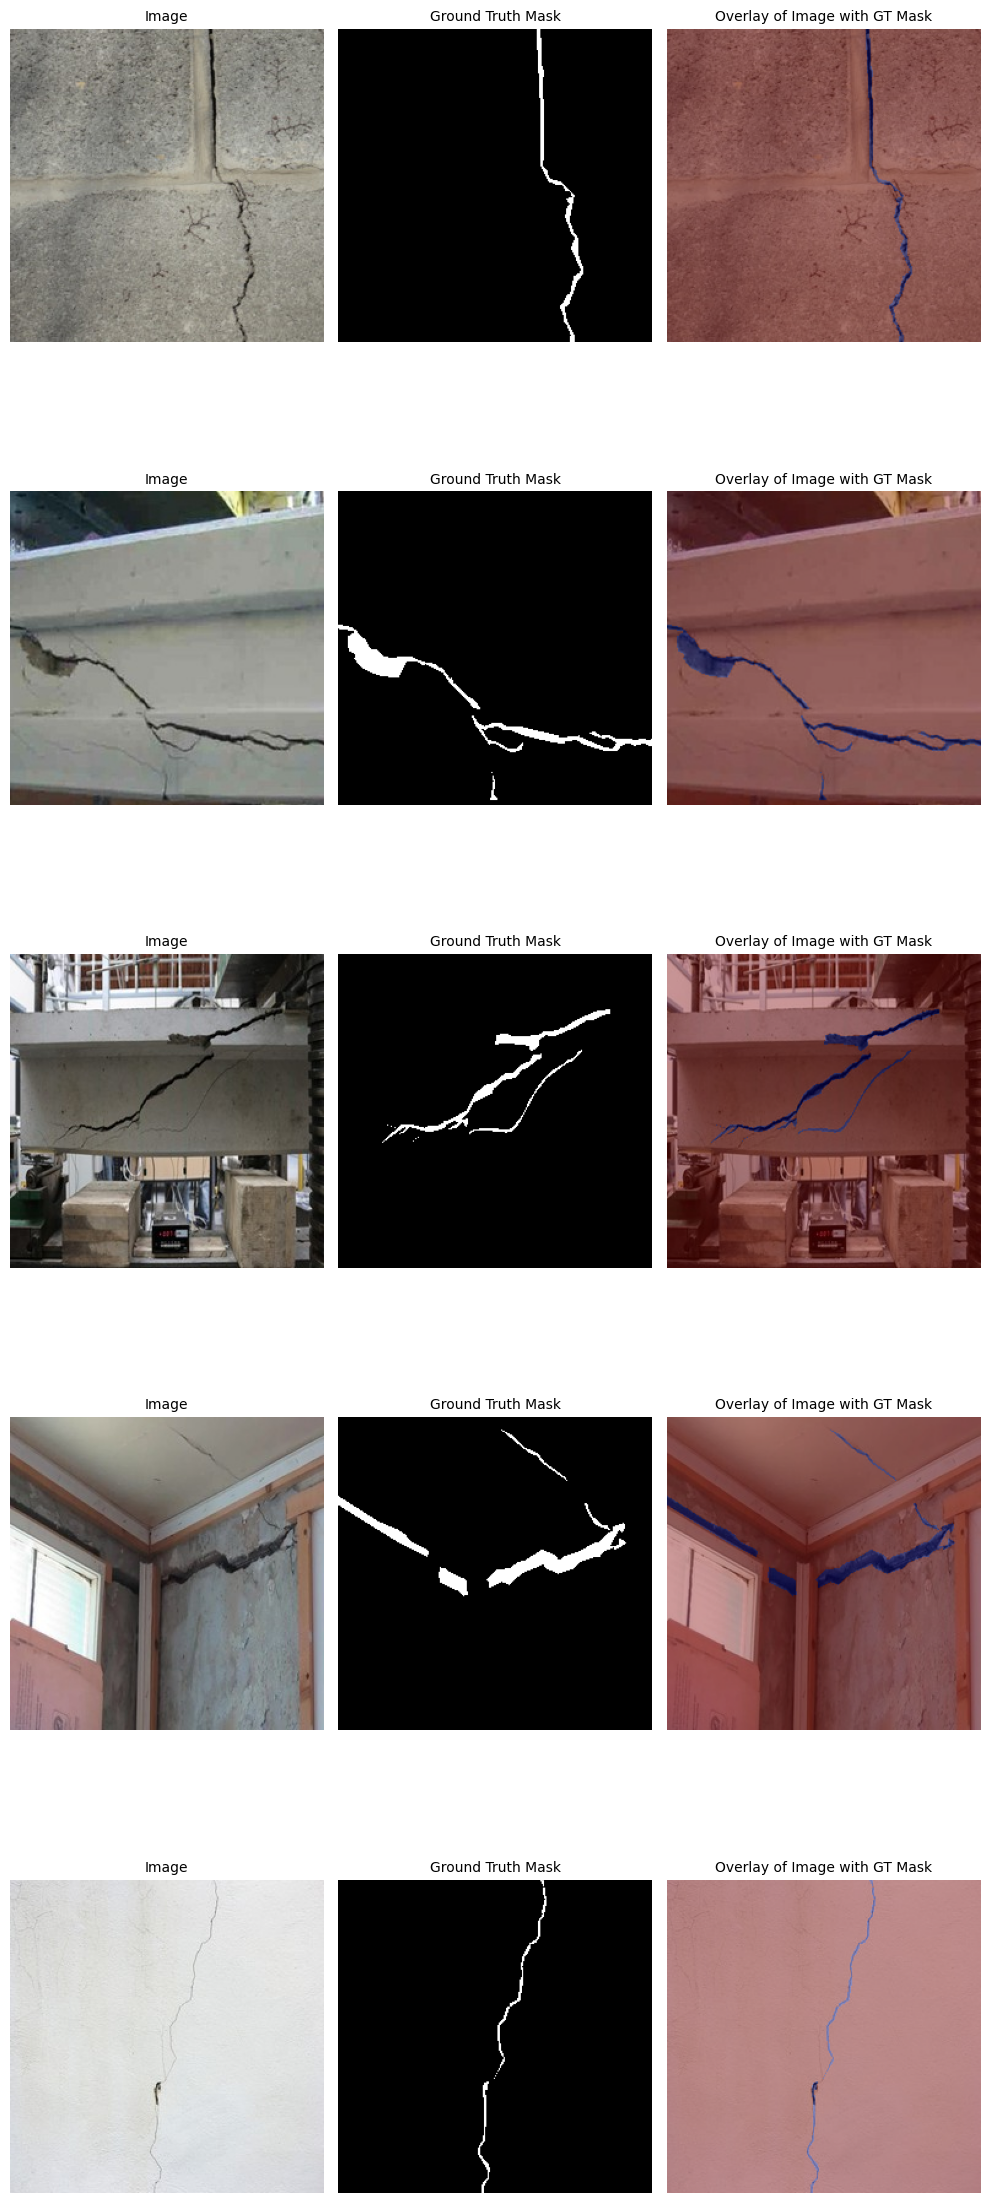

In [119]:
#Training Dataset Visualization:
display_image_grid(train_images_filenames[:5], train_images_dataset_path, train_masks_dataset_path)

In [120]:
#Check the pixel values:
for i, image_filename in enumerate(valid_images_filenames[:5]):
        
        train_mask_path = os.path.join(valid_masks_dataset_path, image_filename.replace(".jpg", ".png")) #mask path
        train_mask = np.array(Image.open(train_mask_path).convert("L"), dtype=np.float32) #open masks from the mask path specified
        print("Unique pixel values in train mask:", np.unique(train_mask))

Unique pixel values in train mask: [  0. 255.]
Unique pixel values in train mask: [  0. 255.]
Unique pixel values in train mask: [  0. 255.]
Unique pixel values in train mask: [  0. 255.]
Unique pixel values in train mask: [  0. 255.]


## Define Pytorch Segmentation Dataset


In [121]:
class SegmentationDataset(Dataset):
    def __init__(self, images_filename, images_directory, masks_directory, transform=None):
        # store the images filenames, images path, masks path, augmentations transform
        self.images_filenames = images_filename
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.images_filenames)
        
    
    def __getitem__(self, index):
        image_filename = self.images_filenames[index]
        image_path = os.path.join(self.images_directory, image_filename)  # provide the image path
        mask_path = os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")) # provide the mask  path

        image = np.array(Image.open(image_path).convert("RGB")) #open images from image path provided (PIL format required by Pytorch)
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32) #open masks from the mask path provided (PIL format required by Pytorch)
        #preprocess mask
        #mask = preprocess_mask(mask)
        mask[mask == 255.0] = 1.0 # for binary segmentation, sigmoid[0-1] as last activation layer

        # check to see if we are applying any transformations
        if self.transform is not None:
           augmentations = self.transform(image=image, mask=mask)
           image = augmentations["image"] # apply the transformations to image
           mask = augmentations["mask"] #apply the transformation to mask

        # return a tuple of images and masks
        return image, mask

## Define the Augmentations (Transformations) applied to training and validation datasets

In [122]:
train_transform = A.Compose(
    [
        #A.PadIfNeeded(min_height=2048, min_width=2048, border_mode=cv2.BORDER_CONSTANT), # Padding if required
        #A.Resize(height = 352, width = 640, interpolation=cv2.INTER_NEAREST), # Resizing if required (maintianing the aspect ratio)
        #A.CenterCrop(height=512, width=512), # Cropping if required
        A.Rotate(limit=45, interpolation=cv2.INTER_NEAREST, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.5, rotate_limit=0, p=0.5),
        #A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Sharpen(alpha=(0.2,0.5), lightness=(0.5,1.0), p=0.5),
        #A.Affine(scale=0.3, translate_percent=0.3, rotate=45, shear=45, p=0.5),
        A.Normalize(
            mean = [0.0,0.0,0.0],
            std = [1.0,1.0,1.0],
            max_pixelvalues=255.0 # dividing by 255.0 to get a value between 0.0 and 1.0 (Binary Segementation)
        ),
        ToTensorV2(), #convert input data to Pytorch Tensor
    ]
    
)

valid_transform = A.Compose(
    [
        #A.Resize(height = 352, width = 640, interpolation=cv2.INTER_NEAREST),
        A.Normalize(
            mean = [0.0,0.0,0.0],
            std = [1.0,1.0,1.0],
            max_pixelvalues=255.0 # dividing by 255.0 to get a value between 0.0 and 1.0 (Binary Segementation)
        ),
    ToTensorV2(),
    ]
)

train_dataset = SegmentationDataset(train_images_filenames, train_images_dataset_path, train_masks_dataset_path, transform=train_transform,) # creating the training dataset with defined augmentation/transformations for Pytorch Dataloader
valid_dataset = SegmentationDataset(valid_images_filenames, valid_images_dataset_path, valid_masks_dataset_path, transform=valid_transform,) # creating the validation dataset with defined augmentations/transformations for Pytorch Dataloader

print(len(train_dataset))
print(len(valid_dataset))

2595
321


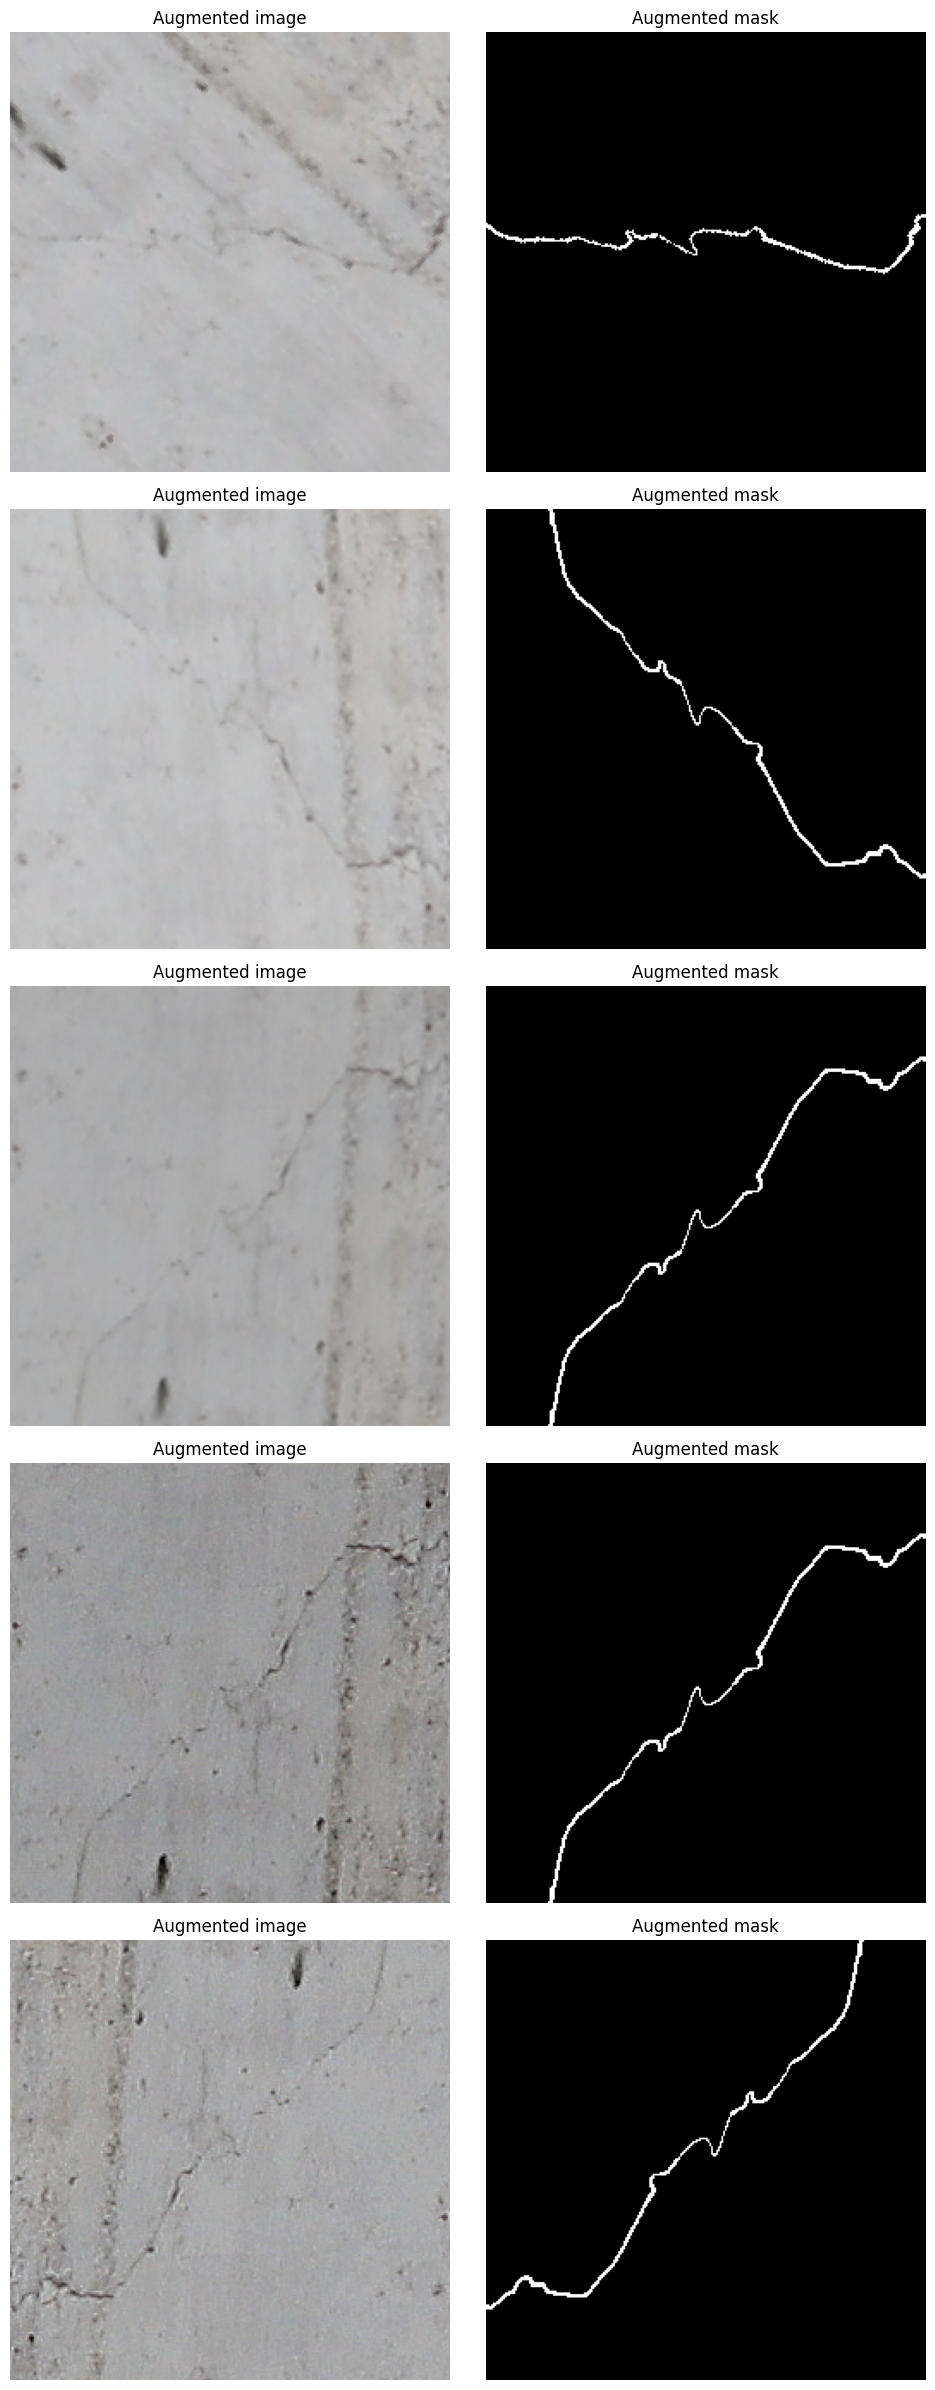

In [123]:
# Visualizing the augmentations (transformations) applied
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset) #so that the original dataset is not affected
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))]) #remove the normalize and ToTensor transformations for visualization purpose
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, cmap='gray')
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()


random.seed(30)
visualize_augmentations(train_dataset, idx=1100)

## Define Segmentation Model

In [25]:
def create_model(params):
    if params["model"] == "UTNET":
        model = UTNet(in_chan=3, base_chan=32, num_classes=1, reduce_size=8, block_list='1234', num_blocks=[1,1,1,1], num_heads=[4,4,4,4], projection='interp', attn_drop=0.1, proj_drop=0.1, rel_pos=True, maxpool=True)  #UTNET model
    elif params["model"] == "CTCNet":
        model = getattr(CTCNet, params["model"])(n_channels=3, n_classes=1) #DTrC Model  
    else:
        raise ValueError(f"Unknown model type: {params['model']}")

    model = model.to(params["device"])
    return model

## Define custom training loss functions and validation evaluation metrics

In [124]:
#Trianining Losses:
def dice_loss(pred, target, threshold, eps=1e-15):
    pred = (pred > threshold).float() #binarize predictions based on the given threshold
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice_loss = 1 - ((2. * intersection + eps) / (union + eps))
    return dice_loss

def soft_jaccard_loss(pred, target, threshold, eps=1e-15):
    pred = (pred > threshold).float() #binarize predictions based on the given threshold
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    soft_jaccard_loss = torch.log((intersection + eps) / (union - intersection + eps))
    return soft_jaccard_loss


class LossBinary_BCEDICE:
    """
    Loss defined as (0.75BCE + 0.25Dice)
    """

    def __init__(self, BCE_weight=0, DICE_weight=0):
        self.BCE_loss = nn.BCEWithLogitsLoss(reduction='mean') #check documentation:https://pytorch.org/docs/stable/nn.html)
        self.BCE_weight = BCE_weight
        self.DICE_weight = DICE_weight

    def __call__(self, pred, target, threshold):
        BCE_loss = self.BCE_loss(pred, target)
        Dice_loss = dice_loss(torch.sigmoid(pred), target, threshold)
        loss = (self.BCE_weight*BCE_loss + self.DICE_weight*Dice_loss)

        return loss 

class LossBinarySoftJaccard:
    """
    Loss defined as \alpha BCE - (1 - \alpha) SoftJaccard (https://github.com/ternaus/robot-surgery-segmentation/blob/master/loss.py)
    """

    def __init__(self, jaccard_weight=0):
        self.BCE_loss = nn.BCEWithLogitsLoss(reduction='mean') #check documentation:https://pytorch.org/docs/stable/nn.html)
        self.jaccard_weight = jaccard_weight

    def __call__(self, pred, target, threshold):
        loss = (1 - self.jaccard_weight) * self.BCE_loss(pred, target) #calculating the BCE componency
        
        if self.jaccard_weight: # calculating the soft Jacarda loss component
           loss -= self.jaccard_weight * soft_jaccard_loss(torch.sigmoid(pred), target, threshold)
        
        return loss
    
# Evaluation Metrics
def dice_score(pred, target, threshold, eps=1e-15):
    pred = (pred > threshold).float() #binarize predictions based on the given threshold
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice_score = (2. * intersection + eps) / (union + eps)
    return dice_score

def IOU_score(pred, target, threshold, eps=1e-15):
    pred = (pred > threshold).float() #binarize predictions based on the given threshold
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    IOU_score = (intersection + eps) / (union + eps)
    return IOU_score

def accuracy(pred, target, threshold):
    pred = (pred > threshold).float() #binarize predictions based on the given threshold
    num_correct = (pred == target).sum()
    num_pixels = torch.numel(target)
    accuracy = num_correct/num_pixels
    return accuracy*100

def precision(pred, target, threshold):
    pred = (pred > threshold).float() #binarize predictions based on the given threshold
    tp = ((pred == 1) & (target == 1)).sum() # True Positives (TP): Both pred and target are 1
    fp = ((pred == 1) & (target == 0)).sum() # False Positives (FP): pred is 1, target is 0
    precision = tp / (tp + fp)
    return precision*100

In [161]:
# EarlyStopping class with a start_epoch parameter
class EarlyStopping:
    def __init__(self, patience=3, start_epoch=100, verbose=False):
        self.patience = patience  # Number of epochs to wait for improvement
        self.start_epoch = start_epoch  # Minimum epochs before early stopping starts
        self.verbose = verbose  # Whether to print early stopping messages
        self.counter = 0  # Number of epochs without improvement
        self.best_score = -float("inf")  # Track the best Dice score
        self.early_stop = False  # Flag to indicate early stopping
        self.best_weights = None  # Store the best model state dict

    def __call__(self, val_metric, model, epoch):
        if epoch < self.start_epoch:  # Check if early stopping should start
            return  # Don't consider early stopping before the start_epoch

        if self.best_score < val_metric:  # If current Dice score is better
            self.best_score = val_metric
            self.save_checkpoint(val_metric, model)  # Save the best model
            self.counter = 0  # Reset the counter
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping patience: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True  # Trigger early stopping

    def save_checkpoint(self, val_metric, model):
        """Save the model when validation Dice score improves."""
        if self.verbose:
            print(f"Validation Dice score improved ({self.best_score:.4f} --> {val_metric:.4f}). Saving model...")
        self.best_weights = copy.deepcopy(model.state_dict()).half()  # Save the model's best weights

#1. Training:

def train(train_loader, model, optimizer, criterion, scaler, epoch, params):

    train_running_loss = 0 #initialize the training running loss
    model.train() #prepare the model for training
    loop = tqdm(train_loader) #progress bar to track the progress of iteration through the batches of training data

    
    #loop over the training dataset
    for batch_idx, (images, targets) in enumerate(loop, start=1):
        
        images = images.to(params["device"], non_blocking =True) #ensuring the computations on GPU
        targets = targets.float().unsqueeze(1).to(params["device"], non_blocking=True) #padding a channel dimension and ensuring the computations on GPU

        #forward propagation
        with torch.cuda.amp.autocast(enabled=True):

            if params["model"] == "DcsNet_deep":
               predictions, deep_sup_1, deep_sup_2 = model(images) #make predictions on the batch of training images
               #After making predictions calculate the loss as monitoring metric for training and updating of model pararmeters (weights and biases)
               loss = criterion(predictions, targets, params["threshold"])
               loss = loss + 0.4*dice_loss(torch.sigmoid(deep_sup_1), targets, params["threshold"]) + 0.4*dice_loss(torch.sigmoid(deep_sup_2), targets, params["threshold"])
               #loss = loss + 0.4*criterion(deep_sup_1, targets, params["threshold"]) + 0.4*criterion(deep_sup_2, targets, params["threshold"])
            else:
               predictions = model(images) #make predictions on the batch of training images
               #After making predictions calculate the loss as monitoring metric for training and updating of model pararmeters (weights and biases)
               loss = criterion(predictions, targets, params["threshold"])

        #backward propagation
        optimizer.zero_grad(set_to_none=True) # Zero any previously accumulated gradients
        scaler.scale(loss).backward()  # Apply the scaled gradients (loss.backward())
        scaler.step(optimizer)  # Take the optimizer step with scaler (optimizer.step())
        scaler.update()  # Now update the scaler for the next iteration
        
        
        #update training loss
        train_running_loss += loss.item() #Note: .item() method in PyTorch is used to extract the scalar value from a tensor that contains only a single element
        train_loss = train_running_loss / batch_idx #average training loss for each batch (dynamic)

        #update the tqdm loop
        mem = f"{torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0:.3g}G"  #memory consumed (GB)
        #loop.set_postfix(loss=loss.item(), train_loss=train_loss)
        loop.set_description("Epoch: {epoch}. Training. Train Loss: {train_loss:.4f}. Memory: {mem}".format(epoch=epoch, train_loss=train_loss, mem=mem))

        #torch.cuda.empty_cache()


    return train_loss


#2. Validation:

def validate(valid_loader, model, epoch, params):

    valid_running_accuracy = 0
    valid_running_dice_score = 0
    valid_running_IOU_score = 0
    
    model.eval() #prepare the evaluation model for validation dataset
    loop = tqdm(valid_loader)


    for batch_idx, (images,targets) in enumerate(loop, start=1):
        images = images.to(params["device"], non_blocking =True) #Ensuring the computations on GPU
        targets = targets.float().unsqueeze(1).to(params["device"], non_blocking=True) #padding a channel dimension and ensuring the computations on GPU

        #forward propagation
        with torch.no_grad():
            
            if params["model"] == "DcsNet_deep":
                predictions, deep_sup_1, deep_sup_2 = model(images)
            else:
                predictions = model(images) #make predictions on the batch of validation images
            
            #After making the predictions calculate the accuracy and dice score as monitoring metric for validation to guide learning of hyperparameters
            accuracy_value = accuracy(torch.sigmoid(predictions), targets, params["threshold"])
            dice_score_value = dice_score(torch.sigmoid(predictions), targets, params["threshold"])
            IOU_score_value = IOU_score(torch.sigmoid(predictions), targets, params["threshold"])

            #update the accuracy and dice score
            valid_running_accuracy += accuracy_value.item()
            valid_accuracy = valid_running_accuracy / batch_idx # average validation accuracy for each batch
            valid_running_dice_score += dice_score_value.item()
            valid_dice_score = valid_running_dice_score / batch_idx
            valid_running_IOU_score += IOU_score_value.item()
            valid_IOU_score = valid_running_IOU_score / batch_idx

            #update the tqdm loop
            loop.set_description("Epoch: {epoch}. Validation. Valid Accuracy: {valid_accuracy:.4f}. Valid Dice Score: {valid_dice_score:.4f}. Valid IOU: {valid_IOU_score:.4f}".format(epoch=epoch, valid_accuracy=valid_accuracy, valid_dice_score=valid_dice_score, valid_IOU_score=valid_IOU_score))

    model.train()

    
    return valid_accuracy, valid_dice_score, valid_IOU_score


def train_and_validate(model, model_name, train_dataset, valid_dataset, params):
    # Create data loaders for training and validation datasets
    train_data_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        num_workers=params["num_workers"],
        shuffle=True,
        pin_memory=True,
    )
    
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=params["batch_size"],
        num_workers=params["num_workers"],
        shuffle=False,
        pin_memory=True,
    )
    
    # Define optimizers, learning rate scheduler, training loss, mixed precision gradient scaler
    #optimizer = optim.Adam(model.parameters(), lr=params["lr"], weight_decay = 0.0001)
    optimizer = optim.SGD(model.parameters(), lr=params["lr"], momentum=0.9, weight_decay=0.0001)
    
    scheduler = optim.lr_scheduler.PolynomialLR(optimizer, total_iters=params["epochs"], power=3)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)
    
    criterion = LossBinary_BCEDICE(BCE_weight=0.5, DICE_weight=0.5)
    #criterion = LossBinarySoftJaccard(jaccard_weight=0.75)
    
    scaler = torch.cuda.amp.GradScaler(enabled=True)

     # Initialize early stopping with a start_epoch threshold
    early_stopping = EarlyStopping(
        patience=params["patience"], 
        start_epoch=100,  # Early stopping starts after 100 epochs
        verbose=True  # Print messages when early stopping occurs
    )
    
    # Initialize a dictionary to store training and validation history
    history = {
        "epochs": [],
        "train_loss": [],
        "valid_accuracy": [],
        "valid_dice_score": [],
        "valid_IOU_score": [],
        "lr": [],
    }
    
    # Check pretrained model weights
    pretrained = params["weights"].endswith(".pth")
    if pretrained:
        ckpt = torch.load(params['weights'], map_location=params["device"])
        model.load_state_dict(ckpt["model"].float().state_dict())
        logging.info(f"Model ckpt loaded from {params['weights']}")
    model.to(params["device"])

    #  Resume
    if pretrained:
        if ckpt["optimizer"] is not None:
            start_epoch = ckpt["epoch"] + 1
            #last_score = ckpt["last_score"]
            optimizer.load_state_dict(ckpt["optimizer"])
            logging.info(f"Optimizer loaded from {params['weights']}")
            if start_epoch < params["epochs"]:
                logging.info(
                    f"{params['weights']} has been trained for {start_epoch} epochs. Fine-tuning for {params['weights']} epochs"
                )
        if "history" in ckpt:  # Check if history dictionary exists in the checkpoint
            history = ckpt["history"]  # Load the history dictionary
    
        del ckpt
    
    start_epoch = 1
    last = f"/home/ali/Segmentation_Project/Outputs/Trained_Weights/{model_name}_last.pth" #path for the pretained saved model
    # Loop over the number of epochs specified in the parameters    
    for epoch in range(start_epoch, params["epochs"] + 1):
        train_loss = train(train_data_loader, model, optimizer, criterion, scaler, epoch, params)
        valid_accuracy, valid_dice_score, valid_IOU_score = validate(valid_data_loader, model, epoch, params)
        scheduler.step()


        # Print the current learning rate
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch}: Current Learning Rate: {current_lr:.6f}")

        # Apply early stopping (Update early stopping based on validation Dice score after 100 epochs)
        early_stopping(valid_dice_score, model, epoch)

        # Stop training if early stopping is triggered
        if early_stopping.early_stop:
            print("Early stopping triggered. Ending training.")
            break

        
        # Update the training and validation history
        history["epochs"].append(epoch)  # No need for .cpu().detach().numpy()
        history["train_loss"].append(train_loss)  # Assuming train_loss is a float
        history["valid_accuracy"].append(valid_accuracy)  # Assuming valid_accuracy is a float
        history["valid_dice_score"].append(valid_dice_score)  # Assuming valid_dice_score is a float
        history["valid_IOU_score"].append(valid_IOU_score)  # Assuming valid_IOU_score is a float
        history["lr"].append(current_lr)

        ckpt = {
            "epoch": epoch,
            "last_dice_score": valid_dice_score,
            "model": copy.deepcopy(model).half(),
            "optimizer": optimizer.state_dict(),
            "history": history,
        }
        
        torch.save(ckpt, last)

     # Restore the best model weights if early stopping occurred
    if early_stopping.best_weights is not None:
        model.load_state_dict(early_stopping.best_weights)
   

    return model, history

## Function to save the trained models and history after training

In [162]:
# Define the root directory to save models and histories
model_save_root_directory = "/home/gyumin/Segmentation_Project/Outputs/Trained_Models"
hisotry_save_root_directory = "/home/gyumin/Segmentation_Project/Outputs/Trained_History"

def save_model_and_history(model, model_name, params, train_dataset, valid_dataset):
    #Train and validation of the model
    model, history = train_and_validate(model, model_name, train_dataset, valid_dataset, params)
    # Save the trained model and training history
    model_savepath = os.path.join(model_save_root_directory, f"{model_name}.pth")
    history_savepath = os.path.join(hisotry_save_root_directory, f"{model_name}.json")

    torch.save(model, model_savepath) #save the complete trained model
    with open(history_savepath, "w") as f: # Open the file in text write mode
        json.dump(history, f) # Dump the dictionary into the filed


## Training and Validation of ResNet-UNet Models

In [ ]:
#Define training parameters
params = {"model": "ResNetUNet",
          "device": "cuda" if torch.cuda.is_available() else "cpu",
          "lr": 0.01,
          "batch_size": 8,
          "num_workers": 2,
          "epochs": 200,
          "threshold": 0.5,
          "patience": 20}

for i in range (1, 2):
    if i == 1: # ResNet18-UNet
       # ResNet18-UNet
        model_ResUNet18 = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", decoder_use_batchnorm=True, in_channels=3, classes=1)
        model_ResUNet18 = model_ResUNet18.to(params["device"])
        pretrained_weights = {"weights": ""} # provide the path to the pretrained weights (if) to resume training
        params.update(pretrained_weights)
        save_model_and_history(model_ResUNet18, "ResUNet18", params, train_dataset, valid_dataset)
    else:
        # ResNet34-UNet
        model_ResUNet34 = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", decoder_use_batchnorm=True, in_channels=3, classes=1)
        model_ResUNet34 = model_ResUNet34.to(params["device"])
        pretrained_weights = {"weights": ""} # provide the path to the pretrained weights (if) to resume training
        params.update(pretrained_weights)
        save_model_and_history(model_ResUNet34, "ResUNet34", params, train_dataset, valid_dataset)

